<a href="https://www.kaggle.com/code/robtheoceanographer/fastclouds?scriptVersionId=95395191" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# FastClouds
This is my project for the first week fo the fast.ai course v5. This is not meant to be a serious project and os just for my own learning experience.

I have not updated this notebook to include steps from lesson2 on data cleaning and data augmentation.

### The Problem
On ground observations are a key part to weather forecasting. Most observations are taken by autonomous systems but there are still a few routine observations that are done manually by a human. One of these is cloud type classification.

This manual observation is currently done is at major airports around Australia. At these airports one or more highly knowledgeable and accredited aerodrome weather observers is stationed to take manual weather observations on a fixed schedule throughout each day. But, having such specialized observers at all airports all of the time is not cost effective or realistically feasible, especially for remote locations (e.g. uninhabited islands or infrequently used aerodromes). Therefore many of these remote or small areas miss out on observations and perhaps receive lower quality situational awareness and forecasts as a result.


### The Solution
Using deep learning and image classification techniques to classifying cloud types from photographs seemed to me a very plausible solution to this problem. Therefore, after the Fastai course v5 lecture 1 I thought I'd try to do exactly that using a visual learner example Jeremy provided as my starting point.

This algorithm uses a resnet and transfer learning as per the original notebook - [is-it-a-bird] -(https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) but it uses three broad categories of clouds instead of just birds vs forests. These classes were chosen as per the work of Luke Howard in "Essay of the Modifications of Clouds" (1803) (https://www.weather.gov/jetstream/corefour).

In order to create a data set duckduckgo was searched for the terms: cirrus clouds, cumulus clouds, stratus clouds

In [1]:
# import shutil
# shutil.rmtree('./cloud_types/')

In [2]:
!pip install --user -qq torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 torchtext==0.10.0
!pip install --user -qq fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

In [4]:
from fastcore.all import *
import time
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
import pathlib


In [5]:
def search_duckduckgo(term, max_images=200):
    """
    Search duckduckgo images for the term
    """
    url = 'https://duckduckgo.com/'
    res = urlread(url, data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data = set(),{'next':1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data = params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

## Lets pull a sample image to see if our search and download code is making sense:

https://images.fineartamerica.com/images-medium-large-5/wispy-cirrus-clouds-pascal-goetgheluckscience-photo-library.jpg


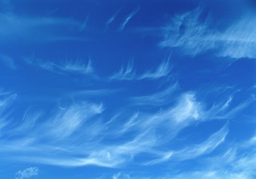

In [6]:
urls = search_duckduckgo('cirrus clouds', max_images = 1)
print(urls[0])
dest = 'cirrus.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

## Download our dataset
Here we download 50 images per search term and put them in to labelled folders ready for modelling.

In [7]:
searches = 'cirrus', 'stratus', 'cumulus'
path = Path('cloud_types')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_duckduckgo(f'{o} clouds', max_images=50))
    resize_images(path/o, max_size=400, dest=path/o)

In [8]:
# Remove any failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Set up and train a model

This is where we create a fastai DataBlock with some basic configs largely the same as Jeremy's original setup.

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.4, seed = 42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

### Here is an example batch of images

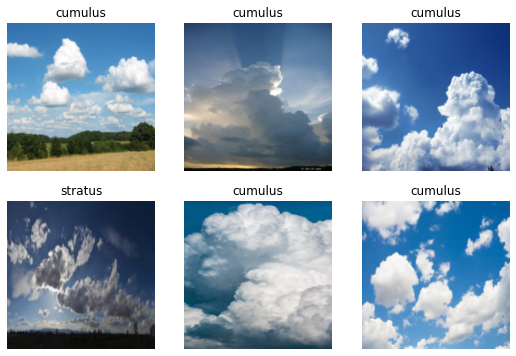

In [10]:
dls.show_batch(max_n=6)

### Train the model

In [12]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
# resnet18, resnet34, resnet50, resnet101, resnet152
# densenet121, densenet169, densenet201, densenet161
learn.fine_tune(25)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.063651,2.497487,0.603448,0.396552,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.547908,2.023076,0.586207,0.413793,00:01
1,1.599820,1.725131,0.603448,0.396552,00:01
2,1.472636,1.473470,0.603448,0.396552,00:01
3,1.240243,1.282577,0.568966,0.431034,00:01
4,1.116020,1.135282,0.448276,0.551724,00:01
5,0.962094,1.009583,0.413793,0.586207,00:01
6,0.862483,0.864133,0.396552,0.603448,00:01
7,0.774192,0.784858,0.362069,0.637931,00:01
8,0.700970,0.768248,0.362069,0.637931,00:01
9,0.631805,0.782509,0.327586,0.672414,00:01


## Data Cleaning

The results seem good for not changing much from the example image classifier but perhaps we can implement a few small adjustments to improve our model performance.

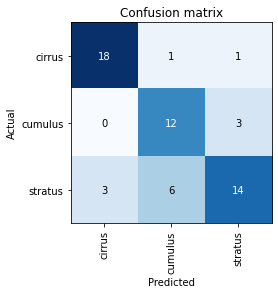

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Looks like our model is confusing stratus for cirrus and also cumulus for stratus but does ok on cirrus. This is most likely a garbage in garbage out problem - e.g. the data is not good and is poorly labelled so we will spend a little bit of time reviewing our input data now.

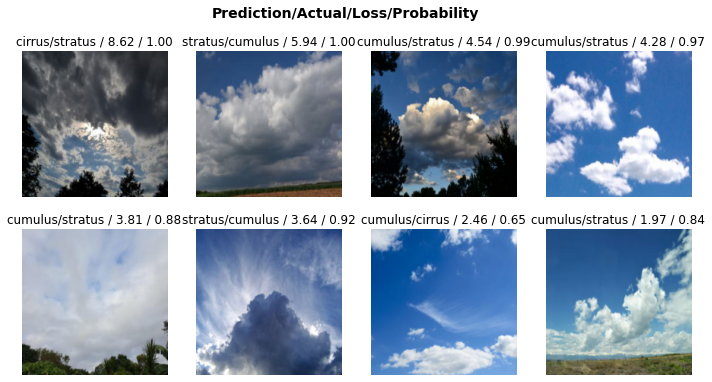

In [14]:
interp.plot_top_losses(8, nrows=2)

Looks like there is some work to be done cleanign up the dataset...

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cloud in cleaner.change(): shutil.move(str(cleaner.fns[idx]), str(path/cloud/pathlib.Path(cleaner.fns[idx]).stem) + '_' + str(pathlib.Path(cleaner.fns[idx]).suffix))
# for idx,cloud in cleaner.change(): shutil.unlink(str(cleaner.fns[idx]))

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.4, seed = 42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.fine_tune(25)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.788674,1.582768,0.763636,0.236364,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.732488,1.432883,0.763636,0.236364,00:01
1,1.639197,1.297373,0.672727,0.327273,00:01
2,1.526614,1.092289,0.490909,0.509091,00:01
3,1.302760,0.900092,0.436364,0.563636,00:01
4,1.097728,0.728460,0.272727,0.727273,00:01
5,0.948715,0.610134,0.236364,0.763636,00:01
6,0.832259,0.556657,0.218182,0.781818,00:01
7,0.727340,0.537241,0.218182,0.781818,00:01
8,0.656060,0.528629,0.200000,0.800000,00:01
9,0.600012,0.501657,0.218182,0.781818,00:01


## Data augmentation

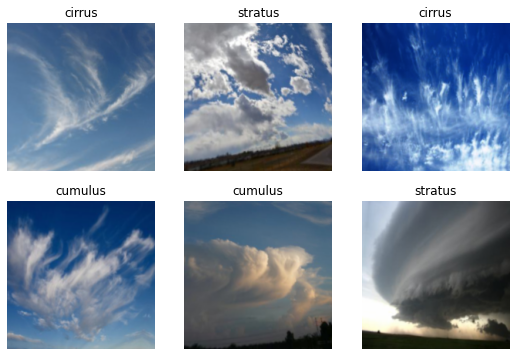

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.4, seed = 42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms()
).dataloaders(path)

dls.show_batch(max_n=6)

In [23]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.fine_tune(25)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.286639,1.784435,0.672727,0.327273,00:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.042964,1.636306,0.690909,0.309091,00:01
1,1.979421,1.457308,0.672727,0.327273,00:01
2,1.784162,1.223460,0.563636,0.436364,00:01
3,1.727901,0.979988,0.436364,0.563636,00:01
4,1.664508,0.772733,0.290909,0.709091,00:01
5,1.541523,0.605656,0.200000,0.800000,00:01
6,1.423124,0.503334,0.145455,0.854545,00:01
7,1.308205,0.438565,0.163636,0.836364,00:01
8,1.191949,0.401739,0.181818,0.818182,00:01
9,1.107202,0.387632,0.200000,0.800000,00:01


# Use the model on our example image

#### use the model on a cirus cloud image:

In [30]:

is_cloud, _, prob = learn.predict(PILImage.create('cirrus.jpg'))

print(f'This is a: {is_cloud}')
print(f'Prob: {prob[0]}')


This is a: cirrus
Prob: 0.9999966621398926


## Conculsion
While this is very basic demo and only about 85% accurate, it shows great potential for automating some of the cloud type observing in remote regions of Australia where there is currnetly limited or no human observer coverage, and therefore this work might benifit from future work.

In [31]:
learn.export('FastCloudsModel.pkl')